# This notebook will create and train the classifier on the chest x-ray dataset to classify whether an image show signs of pneumonia or not

In [2]:
!pip install tensorboard

In [3]:
import torch #torch and torchvision for model and dataloader creation
import torchvision
import tensorboard
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision import transforms #transforms from torchvision for Data Augmentation and Normalization
import torchmetrics #torchmetrics for easy metric computation
import pytorch_lightning as pl #pytorch lightning for efficient and easy training implementation
from pytorch_lightning.callbacks import ModelCheckpoint #ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import tqdm #tqdm for progress par when validating the model
#from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt #matplotlib for visualizing some images

In [4]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [5]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])
val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])

In [6]:
#Create train and val dataset and corresponding data folders
train_dataset = torchvision.datasets.DatasetFolder(
    "Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder(
    "Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)

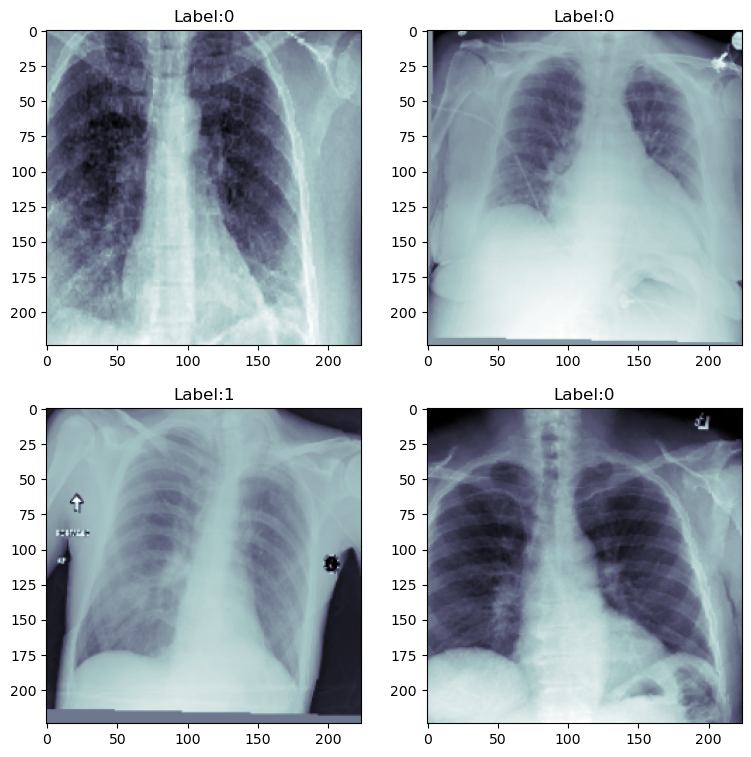

In [7]:
#let's see some agumented train images
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [8]:
batch_size=4
num_workers=1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


In [9]:
#This is imbalance sample we can do either weigheted loss, oversampling or do nothing
np.unique(train_dataset.targets, return_counts=True)
#np.unique(val_datasetrourchvision.models.resent18t.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

In [10]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def on_train_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def on_validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

In [11]:
model = PneumoniaModel()  # Instanciate the model

In [12]:
#To store only the 10 best models based on the validation accuracy
checkpoint_callback = ModelCheckpoint(monitor="Val ACC", save_top_k=10,mode="max")

In [13]:
#Create the trainer
devices = 0  # Set to 1 if you want to use a GPU
gpus = 1 #TODO
trainer = pl.Trainer(accelerator="cpu", logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

#trainer = pl.Trainer(accelerator="cpu", logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
#                     callbacks=checkpoint_callback,
#                     max_epochs=35)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
#Now lets do the training 
#Might crash the code if you do not have enough computing resources
trainer.fit(model, train_loader, val_loader)